# Playground 3:  Segmentation workflow for Nucleophosmin

This notebook contains the workflow for Nucleophosmin, and serves as a starting point for developing a classic segmentation workflow if your data shows similar morphology as Nucleophosmin.

----------------------------------------

Cell Structure Observations:

* [Nucleophosmin](https://www.allencell.org/cell-observations/category/nucleophosmin)

----------------------------------------

Key steps of the workflows:

* Auto-Contrast intensity normalization
* 3D Gaussian smoothing (slice-by-slice)
* Masked-object Thresholding
* 2D spot filters


In [1]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from scipy.ndimage.morphology import binary_fill_holes
from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d
from skimage.morphology import remove_small_objects, binary_closing, ball, disk, erosion, dilation   # function for post-processing (size filter)
from aicssegmentation.core.MO_threshold import MO

## Loading the data

In [2]:
FILE_NAME = '../../data/NPM1/original/3500001991_100X_20180430_1-Scene-10-P10-E04.czi'
reader = AICSImage(FILE_NAME) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(1, 7, 65, 624, 924)


## Preview of the image

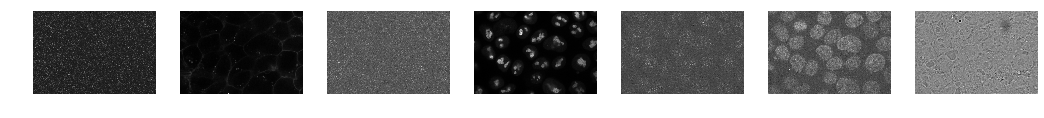

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS>1:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)

In [4]:
#####################
structure_channel = 3
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**: Parameter `intensity_scaling_param` has two options: two values, say `[A, B]`, or single value, say `[K]`. For the first case, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be. For the second case, `K`>0 indicates min-max Normalization with an absolute intensity upper bound `K` (i.e., anything above `K` will be chopped off and reset as the minimum intensity of the stack) and `K`=0 means min-max Normalization without any intensity bound.

    * Parameter for NPM1:  `intensity_scaling_param = [0.5, 15]`


* **Smoothing** 

    3D gaussian smoothing with `gaussian_smoothing_sigma = 1`. The large the value is, the more the image will be smoothed. 

In [5]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [0.5, 15]
gaussian_smoothing_sigma = 1
################################
# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

intensity normalization: normalize into [mean - 0.5 x std, mean + 15 x std] 
intensity normalization completes


In [5]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fe2b987e5…

#### If the contrast looks too off, you can tune the normalization parameters.

We have a function to give you some suggestions. If you have certain preference, you can adjust the values based on the suggestion.

***After you decide the parameters, you have to re-run the code above with the new parameter*** `intensity_scaling_param = `#### If the contrast looks too off, you can play with the normalization parameters

In [6]:
from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(struct_img0)

mean intensity of the stack: 766.451549732319
the standard deviation of intensity of the stack: 530.7459532670317
0.9999 percentile of the stack intensity is: 8604.256099998951
minimum intensity of the stack: 492
maximum intensity of the stack: 8790
suggested upper range is 15.0, which is 8727.640848737794
suggested lower range is 0.5, which is 501.07857309880313
So, suggested parameter for normalization is [0.5, 15.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


### Step 2: Core Algorithm

#### step 2.1: Masked-Object (MO) Thresholding

The basic idea of MO thresholding is to apply a relatively low global threshold to roughly mask out each individual object, and then apply a relatively high threshold within each object. This is meant to handle intensity variation from cell to cell. In general, triangle method and median method are two thresholding algorithms usually yield relatively low threshold. Otsu is used within each object for the relatively high threshold. 

There are two parameters:
* `global_thresh_method`: Support `'tri'`, `'med'`,`'ave'` in current version. `'tri'` is triangle method, `'med'` is median method, `'ave'` is the average of the values returned by triangle method and median method.
* `object_minArea`: The minimal area of connected components after global thresholding to be considered as valid objects. Due to some background noise there could be some small connected components in the global thresholding result. Doing Otsu thresholding within such regions will certainly result in errors. So, we want remove them before doing thresholding within each object.  


Parameter for NPM1:  `global_thresh_method='ave'` and `object_minArea=700`

In [7]:
bw, object_for_debug = MO(structure_img_smooth, global_thresh_method='ave', object_minArea=700, return_object=True)

In [9]:
# view the segmentation result
viewer_bw = view(segmentation_quick_view(bw))
viewer_bw

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

##### After quickly visualizing the segmentation results, you can also visualize the segmentation and original image side by side
##### You may select an ROI to inspect the details

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_bw'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [10]:
# Option 1:
view(seg_fluo_side_by_side(struct_img,bw,roi=['ROI',viewer_bw.roi_slice()]))

# Option 2: 
# view(seg_fluo_side_by_side(struct_img,bw,roi=['M',[570,370,730,440]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

##### If the above segmentation is satisfactory? Here are some possible things to check:
* Is there big missing chunk? Or are segmented chunks are significantly fatter? You may visualize the intermediate result, i.e. the objects, by `view(segmentation_quick_view(object_for_debug))`. By doing this, you can have some sense whether the objects are roughly regions in individual cells. In other words, we want to roughly isolate the stuffs in individual cells. If not, you may change `global_thresh_method`. Three options `'tri'`, `'med'`,`'ave'` are implemented. `'tri'` is triangle method, `'med'` is median method, `'ave'` is the average of the values returned by triangle method and median method. 
* Observing missing chunks may be also due to falsely removed objects. Try to decrease `object_minArea` to be more permisive in segmenting objects.
* Do you observe a chunk of background stuffs in the segmentation? Try to increase `object_minArea` to exclude these background noise. 
* If you observe the segmented objects are slightly fatter than the actual size (may take defraction of light into consideration), don't worry, Next step (2.2) can help the make them thinner. 
* If you observe missing dots in the segmentation, don't worry. Later step (2.3) can pick them up.


#### If the results are satisfactory, go to step 2.2; otherwise, try to tweak the parameters based on the above suggestions. 

Assumption: the segmentation result is saved in a variable named `bw`.

#### step 2.2: Apply 2D spot filte 

Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
* `scale_x` is set based on the estimated radius of your target dots. For example, if visually the diameter of the dots is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have dots of very different sizes.  
* `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf more dots and fatter segmentation, while larger `cutoff_x` could be less permisive and yield less dots and slimmer segmentation. 

We want to apply S2 filter in two ways: one on the original image to detect extra bright spots, and another one on the inverse of the original image to detect dark spots to remove

Parameter for extra bright spots:  `s2_param_bright = [[2, 0.025]]`
Parameter for dark spots:  `s2_param_dark = [[2, 0.025], [1, 0.025]]`

In [12]:
######
s2_param_bright = [[2, 0.025]]
s2_param_dark = [[2, 0.025], [1, 0.025]]
######

bw_extra = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param_bright)
bw_dark = dot_2d_slice_by_slice_wrapper(1-structure_img_smooth, s2_param_dark)

In [13]:
view(segmentation_quick_view(bw_extra))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

In [14]:
view(segmentation_quick_view(bw_dark))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

#### step 2.3: merge the results

In [16]:
bw_merge = np.logical_or(bw, bw_extra)
bw_merge[bw_dark>0]=0

In [17]:
view(segmentation_quick_view(bw_merge))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

#### Step 3: Post-Processing 

In [18]:
################################
## PARAMETERS for this step ##
minArea = 10
################################

seg = remove_small_objects(bw_merge>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [19]:
view(seg_fluo_side_by_side(struct_img, seg))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

### You can also focus your inspection on a small ROI

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_final'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [21]:
# Option 1: 
view(seg_fluo_side_by_side(struct_img, seg, roi=['ROI',viewer_final.roi_slice()]))

# Option 2: 
#view(seg_fluo_side_by_side(struct_img, seg, roi=['M',[267,440, 468, 605]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

### You may also physically save the segmentation results into a ome.tif file

In [82]:
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter('../../data/NPM1/result/3500001289_100X_20170915_25_44_1-Scene-11-P39-E08_test_segmentation.tiff')
writer.save(out)